# Predictive Maintenance with Azure Dataset

## Project imports

In [60]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

## Data Imports

Importing data from downloaded files and creating dataframes for each file:

**Telemetry**

This dataset contains telemetry data collected from machines at different timestamps. It includes measurements of voltage, rotation, pressure, and vibration.

- Columns: `datetime`, `machineID`, `volt`, `rotate`, `pressure`, `vibration`

**Errors**

This dataset records the occurrence of errors in machines at different timestamps. Each error is identified by an error code.

- Columns: `datetime`, `machineID`, `errorID`

**Failures**

This dataset tracks the failures of machines at different timestamps. Each failure is associated with a specific component.

- Columns: `datetime`, `machineID`, `failure`

**Machines**

This dataset contains information about the machines, including their IDs, models, and ages.

- Columns: `machineID`, `model`, `age`

**Maintenance**

This dataset logs the maintenance activities performed on machines at different timestamps. Each maintenance record is associated with a specific component.

- Columns: `datetime`, `machineID`, `comp`

In [61]:
def read(name: str, parse_dates: list[str] | None = ["datetime"]) -> pd.DataFrame:
    path = "data/"
    ext = ".csv"
    file = path + name + ext
    return pd.read_csv(file, parse_dates=parse_dates)


telemetry = read("PdM_telemetry")
errors = read("PdM_errors")
failures = read("PdM_failures")
maint = read("PdM_maint")
machines = read("PdM_machines", parse_dates=None)

### Merging all the dataframes into a single dataframe:

- Merging `telemetry`, `errors`, `failures`, `machines`, and `maintenance` dataframes into a single dataframe `df` using the `machineID` and `datetime` columns as keys.

In [62]:
from functools import reduce

# Merge 'telemetry' last to reduce cost of joining operations
dataframes = [errors, failures, maint, telemetry]
data = reduce(
    lambda left, right: pd.merge(
        left, right, on=["datetime", "machineID"], how="outer"
    ),
    dataframes,
)

# Merge 'machines' separately on 'machineID'
data = data.merge(machines, on="machineID", how="outer")

# Sort by 'machineID' and 'datetime'
data = data.sort_values(by=["machineID" , "datetime"])

print(data.head())

             datetime  machineID errorID failure   comp        volt  \
0 2014-06-01 06:00:00          1     NaN     NaN  comp2         NaN   
1 2014-07-16 06:00:00          1     NaN     NaN  comp4         NaN   
2 2014-07-31 06:00:00          1     NaN     NaN  comp3         NaN   
3 2014-12-13 06:00:00          1     NaN     NaN  comp1         NaN   
4 2015-01-01 06:00:00          1     NaN     NaN    NaN  176.217853   

       rotate    pressure  vibration   model  age  
0         NaN         NaN        NaN  model3   18  
1         NaN         NaN        NaN  model3   18  
2         NaN         NaN        NaN  model3   18  
3         NaN         NaN        NaN  model3   18  
4  418.504078  113.077935  45.087686  model3   18  


### Saving merged dataframe to a CSV file for future use.

In [63]:
# Replace missing values for better visualization in csv file
raw_data = data.fillna("NaN")

raw_data.to_csv("data/raw_data.csv", index=False)

### Graph of raw data

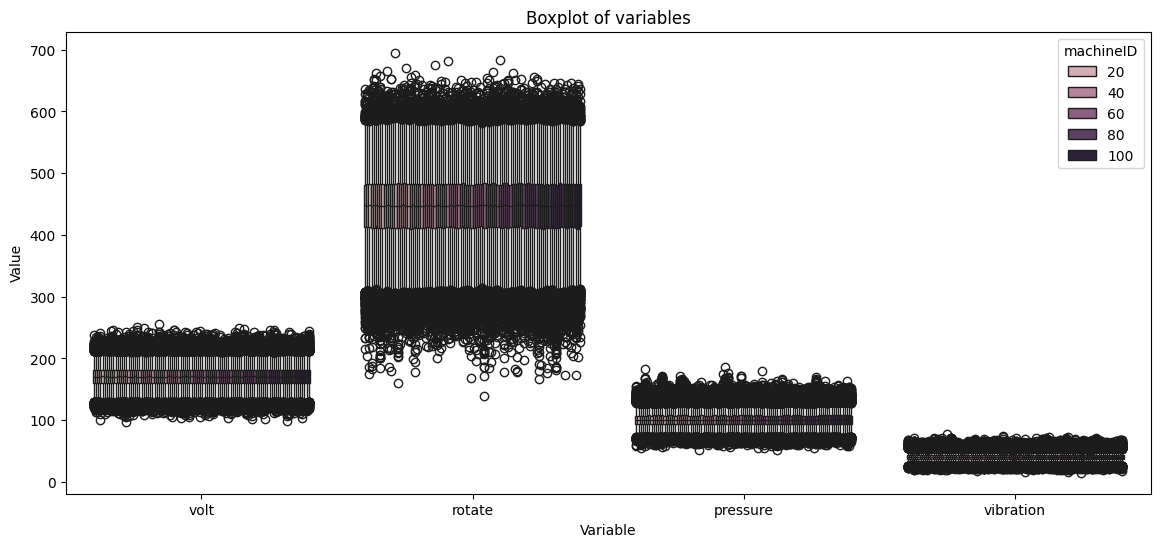

In [64]:
variables = ["volt", "rotate", "pressure", "vibration"]
filtered_data = data.dropna(subset=variables)
melted_data = pd.melt(filtered_data, id_vars=["datetime", "machineID"], value_vars=variables)

plt.figure(figsize=(14, 6))
sns.boxplot(x="variable", y="value", hue="machineID", data=melted_data)
plt.title("Boxplot of variables")
plt.xlabel("Variable")
plt.ylabel("Value")
plt.show()

## Pre-processing

Pre-processing the data to prepare it for predictive maintenance.

### Removing suspected abnormal data

In [65]:
time_before = 48
time_after = 6

normal_behavior_data = data.copy()
variables = ["volt", "rotate", "pressure", "vibration"]
normal_behavior_data = normal_behavior_data.dropna(subset=variables)
normal_behavior_data = normal_behavior_data.drop(columns=["errorID", "failure", "comp"])
anomalies = [failures, errors, maint]

# Create a DataFrame of all the windows around the anomalies
windows = pd.concat(
    [
        anomaly.assign(
            start=anomaly["datetime"] - pd.Timedelta(hours=time_before),
            end=anomaly["datetime"] + pd.Timedelta(hours=time_after),
        )
        for anomaly in anomalies
    ]
)

# Initialize a mask with all False
mask = pd.Series([False] * len(normal_behavior_data), index=normal_behavior_data.index)

# Update mask for each window values
for _, window in windows.iterrows():
    mask |= (
        (normal_behavior_data["machineID"] == window["machineID"])
        & (normal_behavior_data["datetime"] >= window["start"])
        & (normal_behavior_data["datetime"] <= window["end"])
    )

# Create a DataFrame with the removed data
removed_data = normal_behavior_data[mask]

# Filter normal_behavior_data
normal_behavior_data = normal_behavior_data[~mask]

print(normal_behavior_data.head())

               datetime  machineID        volt      rotate    pressure  \
4   2015-01-01 06:00:00          1  176.217853  418.504078  113.077935   
108 2015-01-05 13:00:00          1  180.511003  429.058686  107.314608   
109 2015-01-05 14:00:00          1  174.675215  396.757832  111.505227   
110 2015-01-05 15:00:00          1  181.406935  575.505189  102.008082   
111 2015-01-05 16:00:00          1  197.636954  448.467915   78.721961   

     vibration   model  age  
4    45.087686  model3   18  
108  39.232469  model3   18  
109  33.156011  model3   18  
110  38.054036  model3   18  
111  34.367747  model3   18  


### Identifying machine expected behavior

In [66]:
from scipy.stats import kurtosis, skew, t


def calculate_statistics(
    machine_data: pd.DataFrame, machine_id: str | int
) -> list[dict]:
    variables = ["volt", "rotate", "pressure", "vibration"]
    results = []
    for var in variables:
        machine_var = machine_data[var]
        mean = machine_var.mean()
        std = machine_var.std()
        n = machine_var.count()
        confidence_interval = t.interval(0.95, df=n - 1, loc=mean, scale=std / np.sqrt(n))
        q1 = machine_var.quantile(0.25)
        q3 = machine_var.quantile(0.75)
        iqr = q3 - q1
        lower_fence = q1 - 1.5 * iqr
        upper_fence = q3 + 1.5 * iqr
        outliers = machine_var[(machine_var < lower_fence) | (machine_var > upper_fence)]
        
        results.append({
            "machineID": machine_id,
            "variable": var,
            "mean": mean,
            "median": machine_var.median(),
            "std": std,
            "confidence_interval_95": confidence_interval,
            "skew": skew(machine_var),
            "kurtosis": kurtosis(machine_var),
            "min": machine_var.min(),
            "lower_fence": lower_fence,
            "q1": q1,
            "q3": q3,
            "upper_fence": upper_fence,
            "max": machine_var.max(),
            "outliers": outliers.values.tolist()
        })
    return results


# Results for the entire dataset
results = calculate_statistics(normal_behavior_data, "all")

# Results for each machine
results += [
    result
    for id in normal_behavior_data["machineID"].unique()
    for result in calculate_statistics(
        normal_behavior_data[normal_behavior_data["machineID"] == id], id
    )
]

# Convert the results to a DataFrame
results_df = pd.DataFrame(results)
print(results_df.head(4))

  machineID   variable        mean      median        std  \
0       all       volt  170.585667  170.453691  15.378671   
1       all     rotate  447.774725  448.413383  51.820495   
2       all   pressure  100.673857  100.335225  10.832220   
3       all  vibration   40.292168   40.181184   5.278982   

                     confidence_interval_95      skew  kurtosis         min  \
0   (170.5473486438166, 170.62398550059842)  0.066006  0.079516   97.333604   
1    (447.6456062965298, 447.9038444620059) -0.095101  0.136754  160.258190   
2  (100.64686638533253, 100.70084681439623)  0.334694  0.729312   51.237106   
3    (40.27901420978728, 40.30532107051222)  0.192482  0.355528   14.877054   

   lower_fence          q1          q3  upper_fence         max  \
0   129.315043  160.203042  180.795042   211.683041  250.870453   
1   309.901260  413.610414  482.749849   586.459003  695.020984   
2    72.543442   93.446370  107.381656   128.284584  182.111770   
3    26.322213   36.741937   4

### Graphical representation of the data

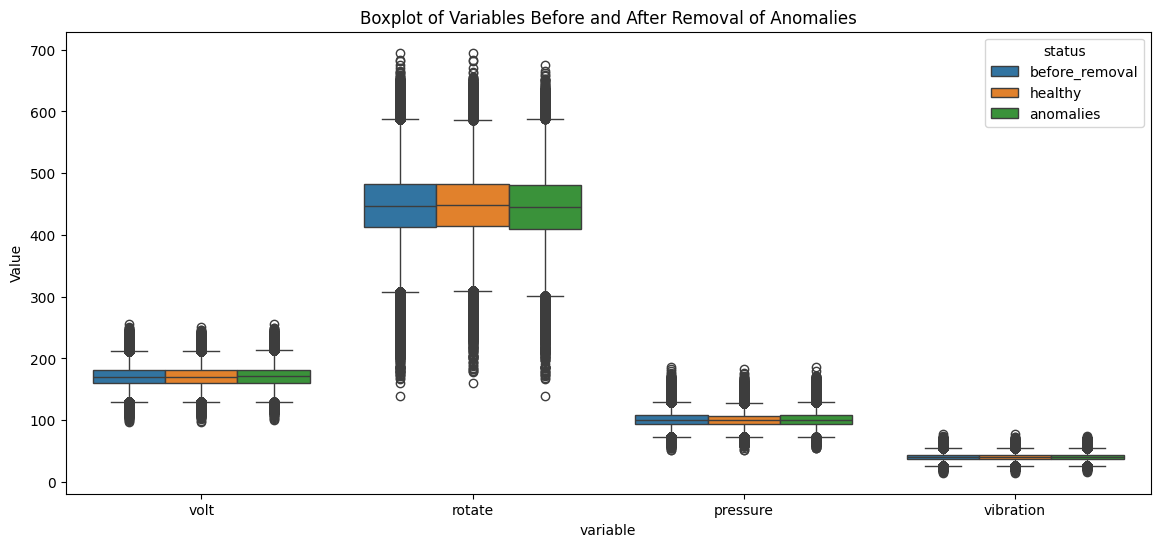

In [67]:
full_data = filtered_data.copy()
full_data["status"] = "before_removal"
normal_behavior_data["status"] = "healthy"
removed_data["status"] = "anomalies"

# Combine the two DataFrames
combined_data = pd.concat([full_data, normal_behavior_data, removed_data])

# Melt the DataFrame
melted_data = pd.melt(
    combined_data, id_vars=["machineID", "status"], value_vars=variables
)

# Create the boxplot
plt.figure(figsize=(14, 6))
sns.boxplot(x="variable", y="value", hue="status", data=melted_data)
plt.title("Boxplot of Variables Before and After Removal of Anomalies")
plt.ylabel("Value")
plt.show()

#### Standardized plot

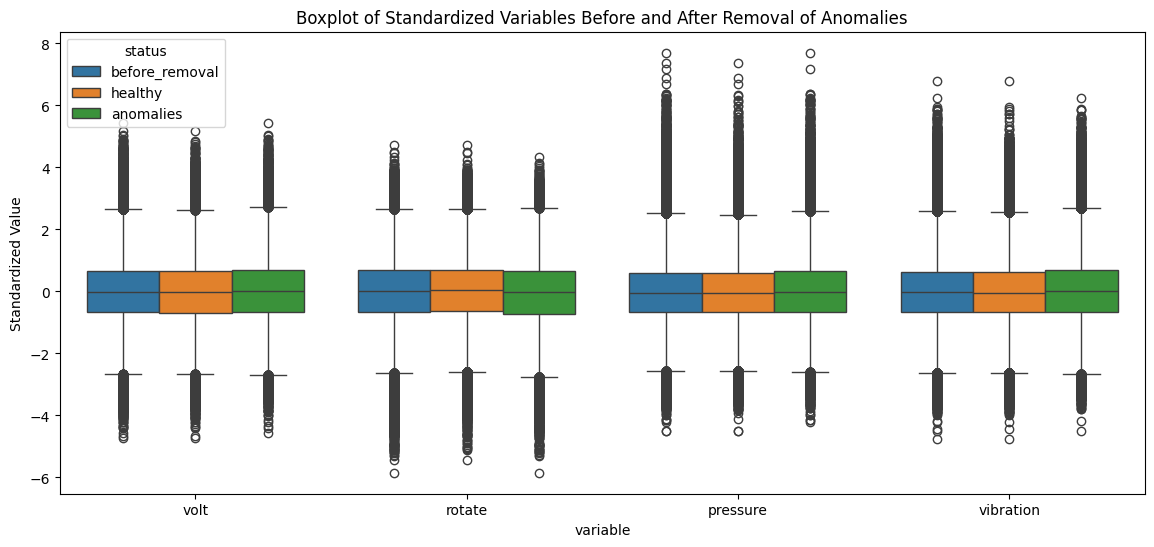

In [68]:
from sklearn.preprocessing import StandardScaler

# Standardize the variables
scaler = StandardScaler()
standard_data = combined_data.copy()
standard_data[variables] = scaler.fit_transform(combined_data[variables])

# Melt the DataFrame
melted_data = pd.melt(
    standard_data, id_vars=["machineID", "status"], value_vars=variables
)

# Create the boxplot
plt.figure(figsize=(14, 6))
sns.boxplot(x="variable", y="value", hue="status", data=melted_data)
plt.title("Boxplot of Standardized Variables Before and After Removal of Anomalies")
plt.ylabel("Standardized Value")
plt.show()

#### Standardization for individual machines

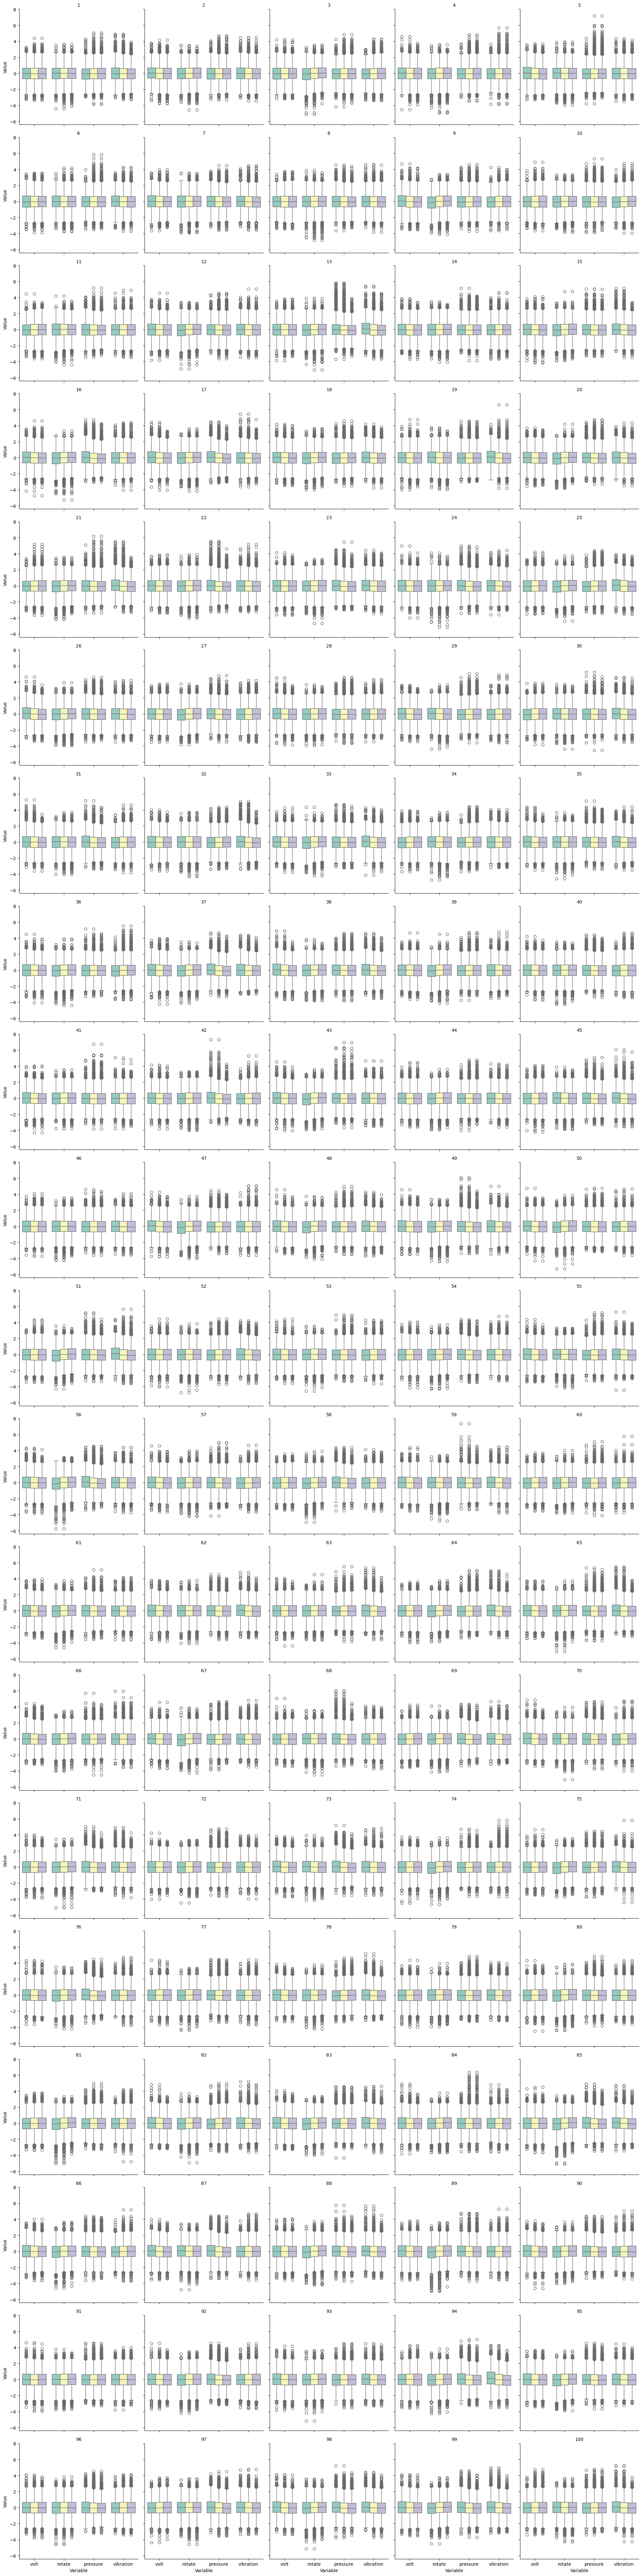

In [69]:
# Standardize values for each 'machineID'
standard_data = combined_data.copy()
for variable in variables:
    standard_data[variable] = combined_data.groupby("machineID")[variable].transform(
        lambda x: (x - x.mean()) / x.std()
    )
melted_data = pd.melt(
    standard_data, id_vars=["machineID", "status"], value_vars=variables
)

# Create a FacetGrid with 'machineID' on the columns
g = sns.FacetGrid(melted_data, col="machineID", col_wrap=5, height=4, aspect=1)

# Get the unique status values and sort them
status_values = sorted(melted_data["status"].unique())

# Map a boxplot onto each subplot
g.map(
    sns.boxplot,
    "variable",
    "value",
    "status",
    palette="Set3",
    order=variables,
    hue_order=status_values,
)
g.set_titles("{col_name}")
g.set_axis_labels("Variable", "Value")
plt.show()

#### Time series plot for individual machines

Only shown the first machine as an example.

In [70]:
first_machine_data = standard_data[
    standard_data["machineID"] == standard_data["machineID"].min()
]

# Find all duplicated datetime values
duplicated_datetimes = first_machine_data[
    first_machine_data.duplicated("datetime", keep=False)
]["datetime"]

# Print all duplicated datetime values
print(duplicated_datetimes)

4      2015-01-01 06:00:00
5      2015-01-01 07:00:00
6      2015-01-01 08:00:00
7      2015-01-01 09:00:00
8      2015-01-01 10:00:00
               ...        
8753   2015-12-31 08:00:00
8754   2015-12-31 09:00:00
8755   2015-12-31 10:00:00
8756   2015-12-31 11:00:00
8757   2015-12-31 12:00:00
Name: datetime, Length: 17544, dtype: datetime64[ns]


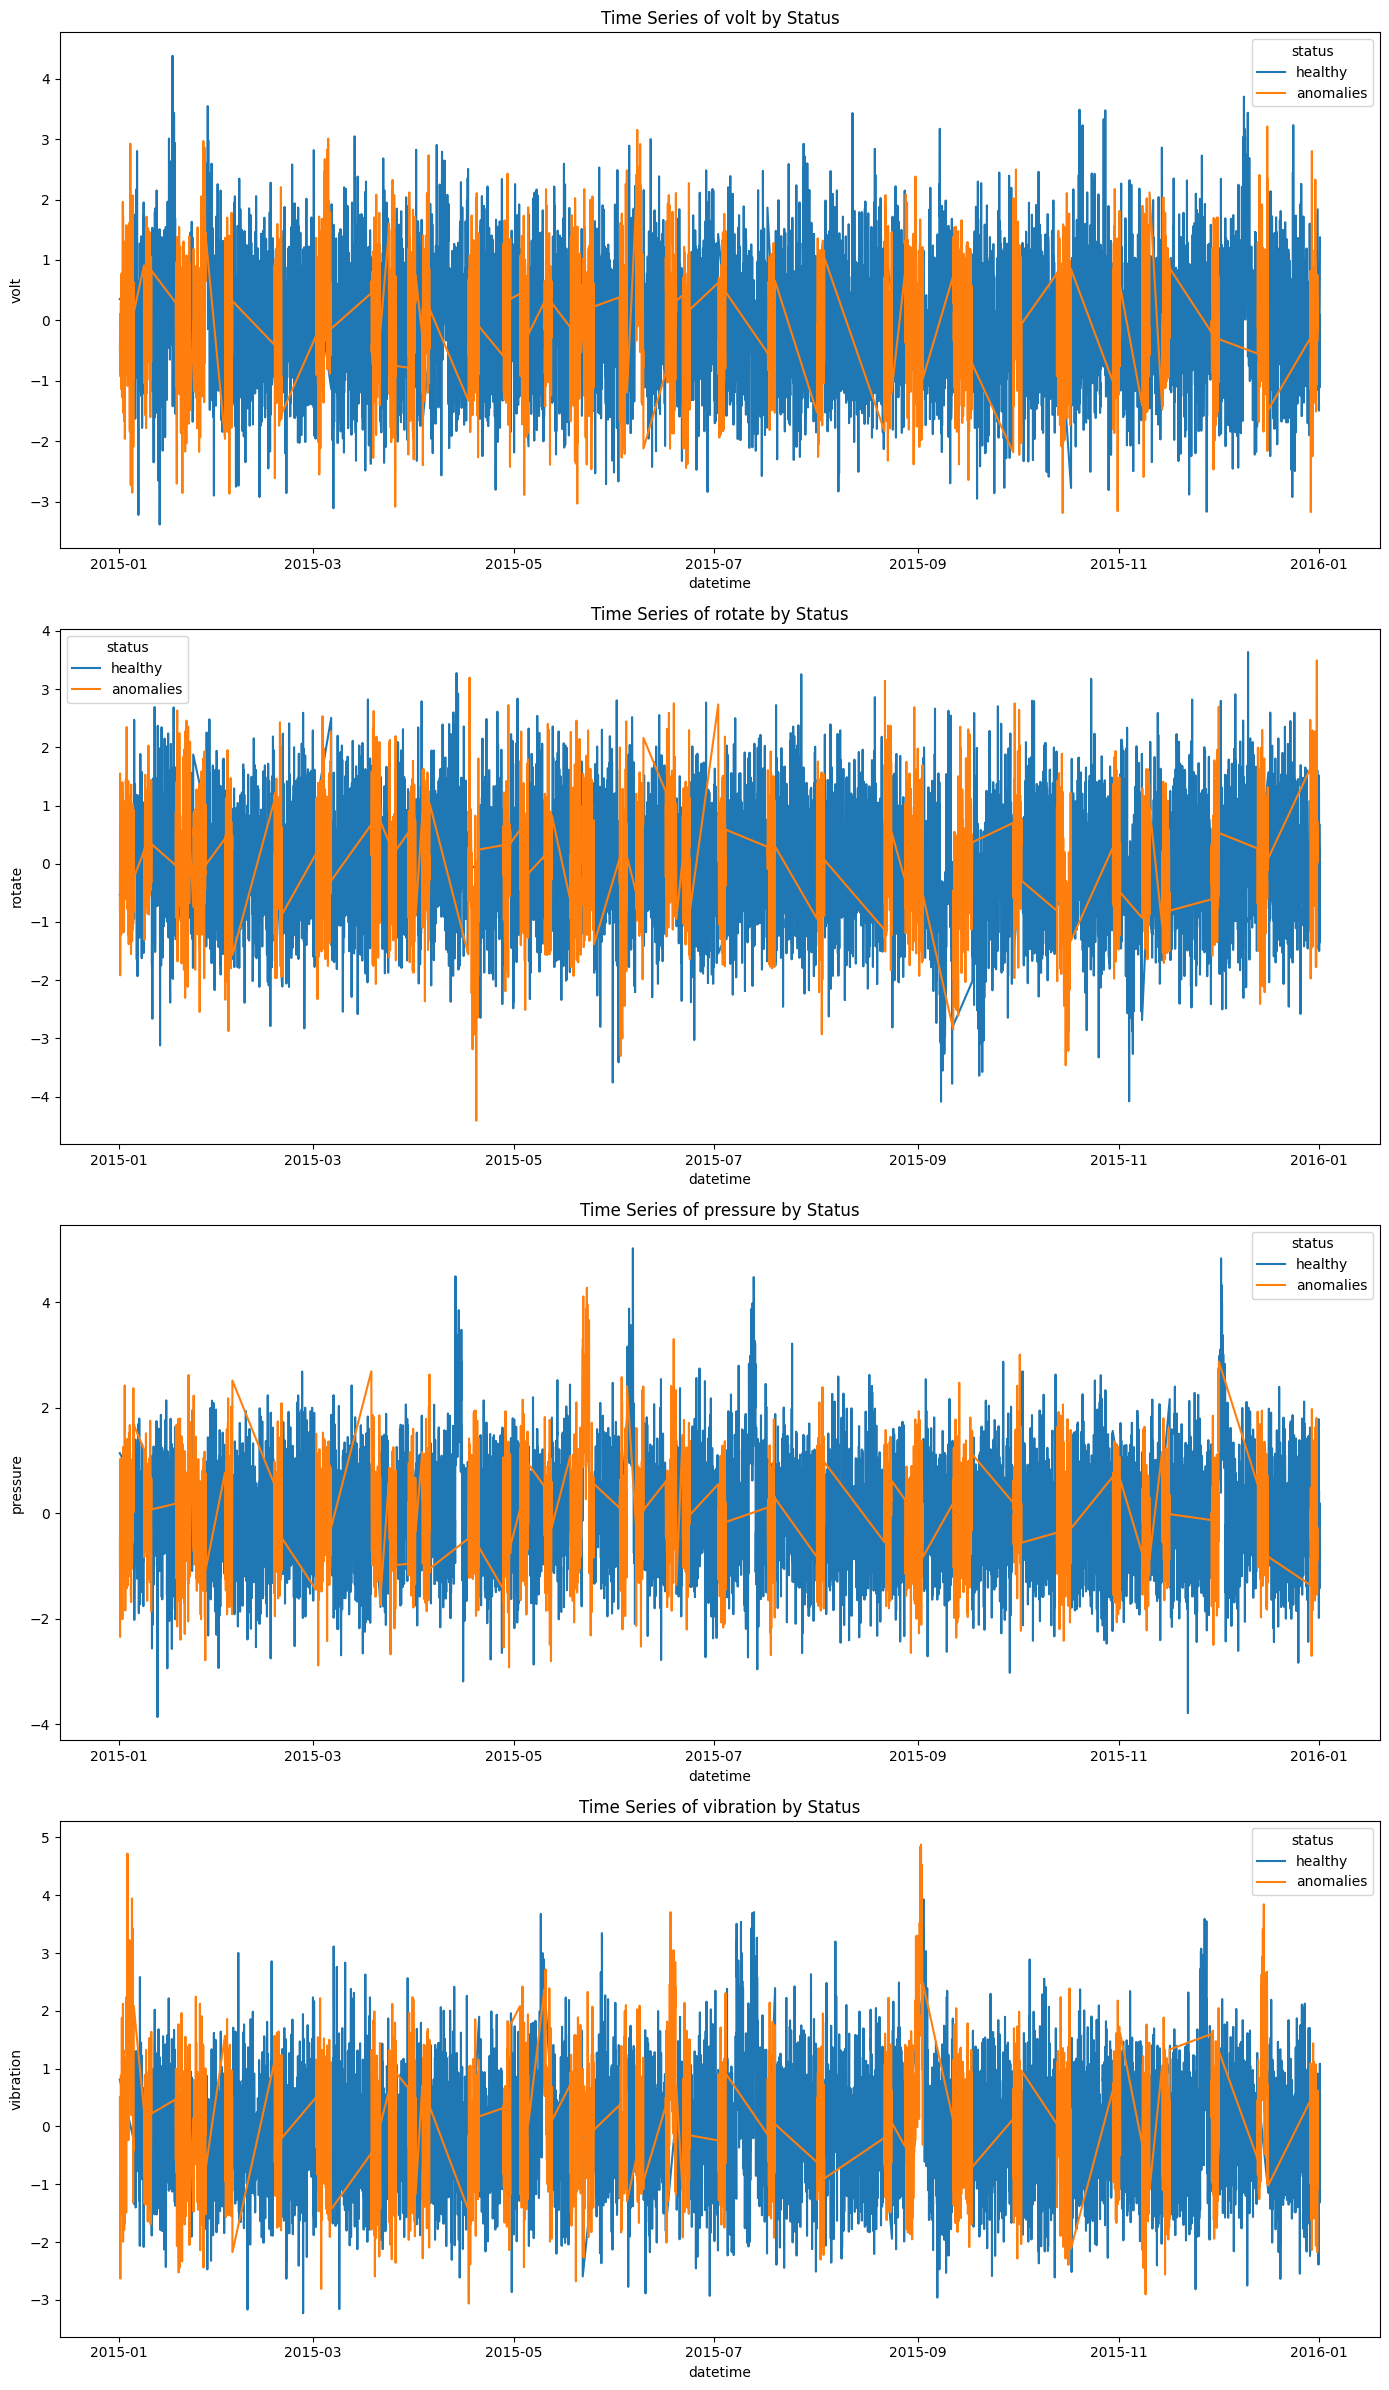

In [71]:
first_machine_data = standard_data[
    (standard_data["machineID"] == standard_data["machineID"].min()) & (standard_data["status"] != "before_removal")
]

fig, axes = plt.subplots(len(variables), figsize=(14, 6 * len(variables)))
for ax, variable in zip(axes, variables):
    sns.lineplot(x="datetime", y=variable, hue="status", data=first_machine_data, ax=ax)
    ax.set_title(f"Time Series of {variable} by Status")
plt.tight_layout()
plt.show()

#### Removing noise from the data

- Rolling mean

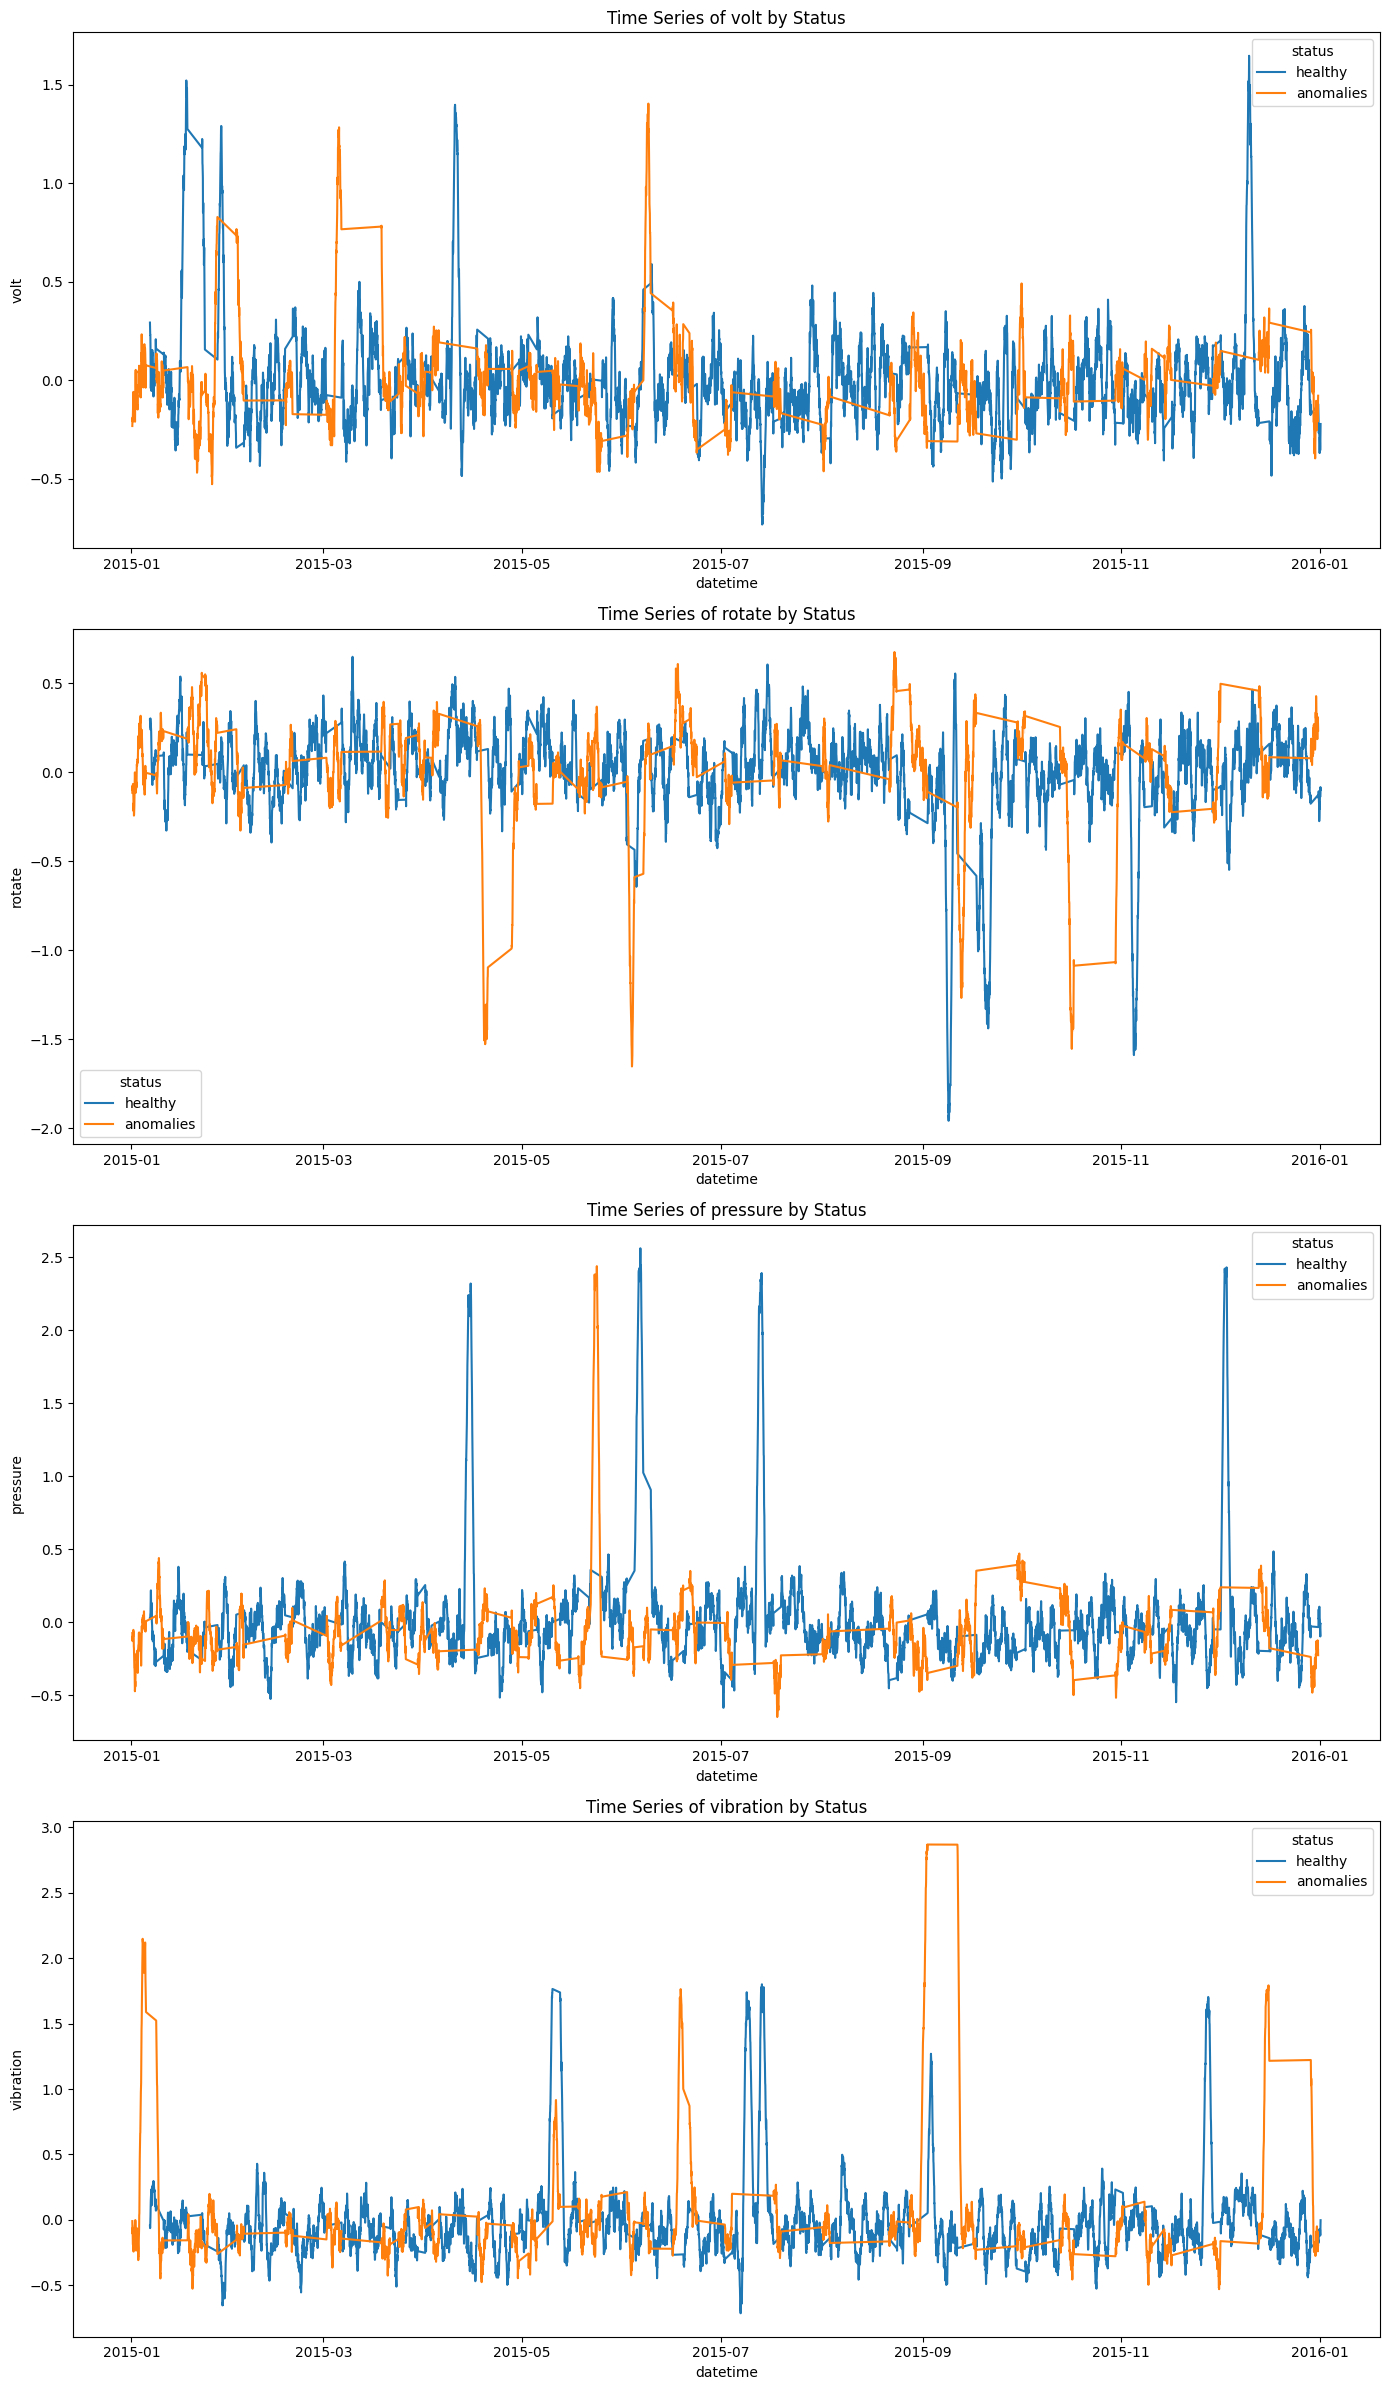

In [72]:
window_size = 30
first_machine_data_smooth = first_machine_data.copy()

for variable in variables:
    first_machine_data_smooth[variable] = (
        first_machine_data_smooth[variable].rolling(window_size).mean()
    )

fig, axes = plt.subplots(len(variables), figsize=(14, 6 * len(variables)))
for ax, variable in zip(axes, variables):
    sns.lineplot(
        x="datetime", y=variable, hue="status", data=first_machine_data_smooth, ax=ax
    )
    ax.set_title(f"Time Series of {variable} by Status")
plt.tight_layout()
plt.show()

- Exponential smoothing

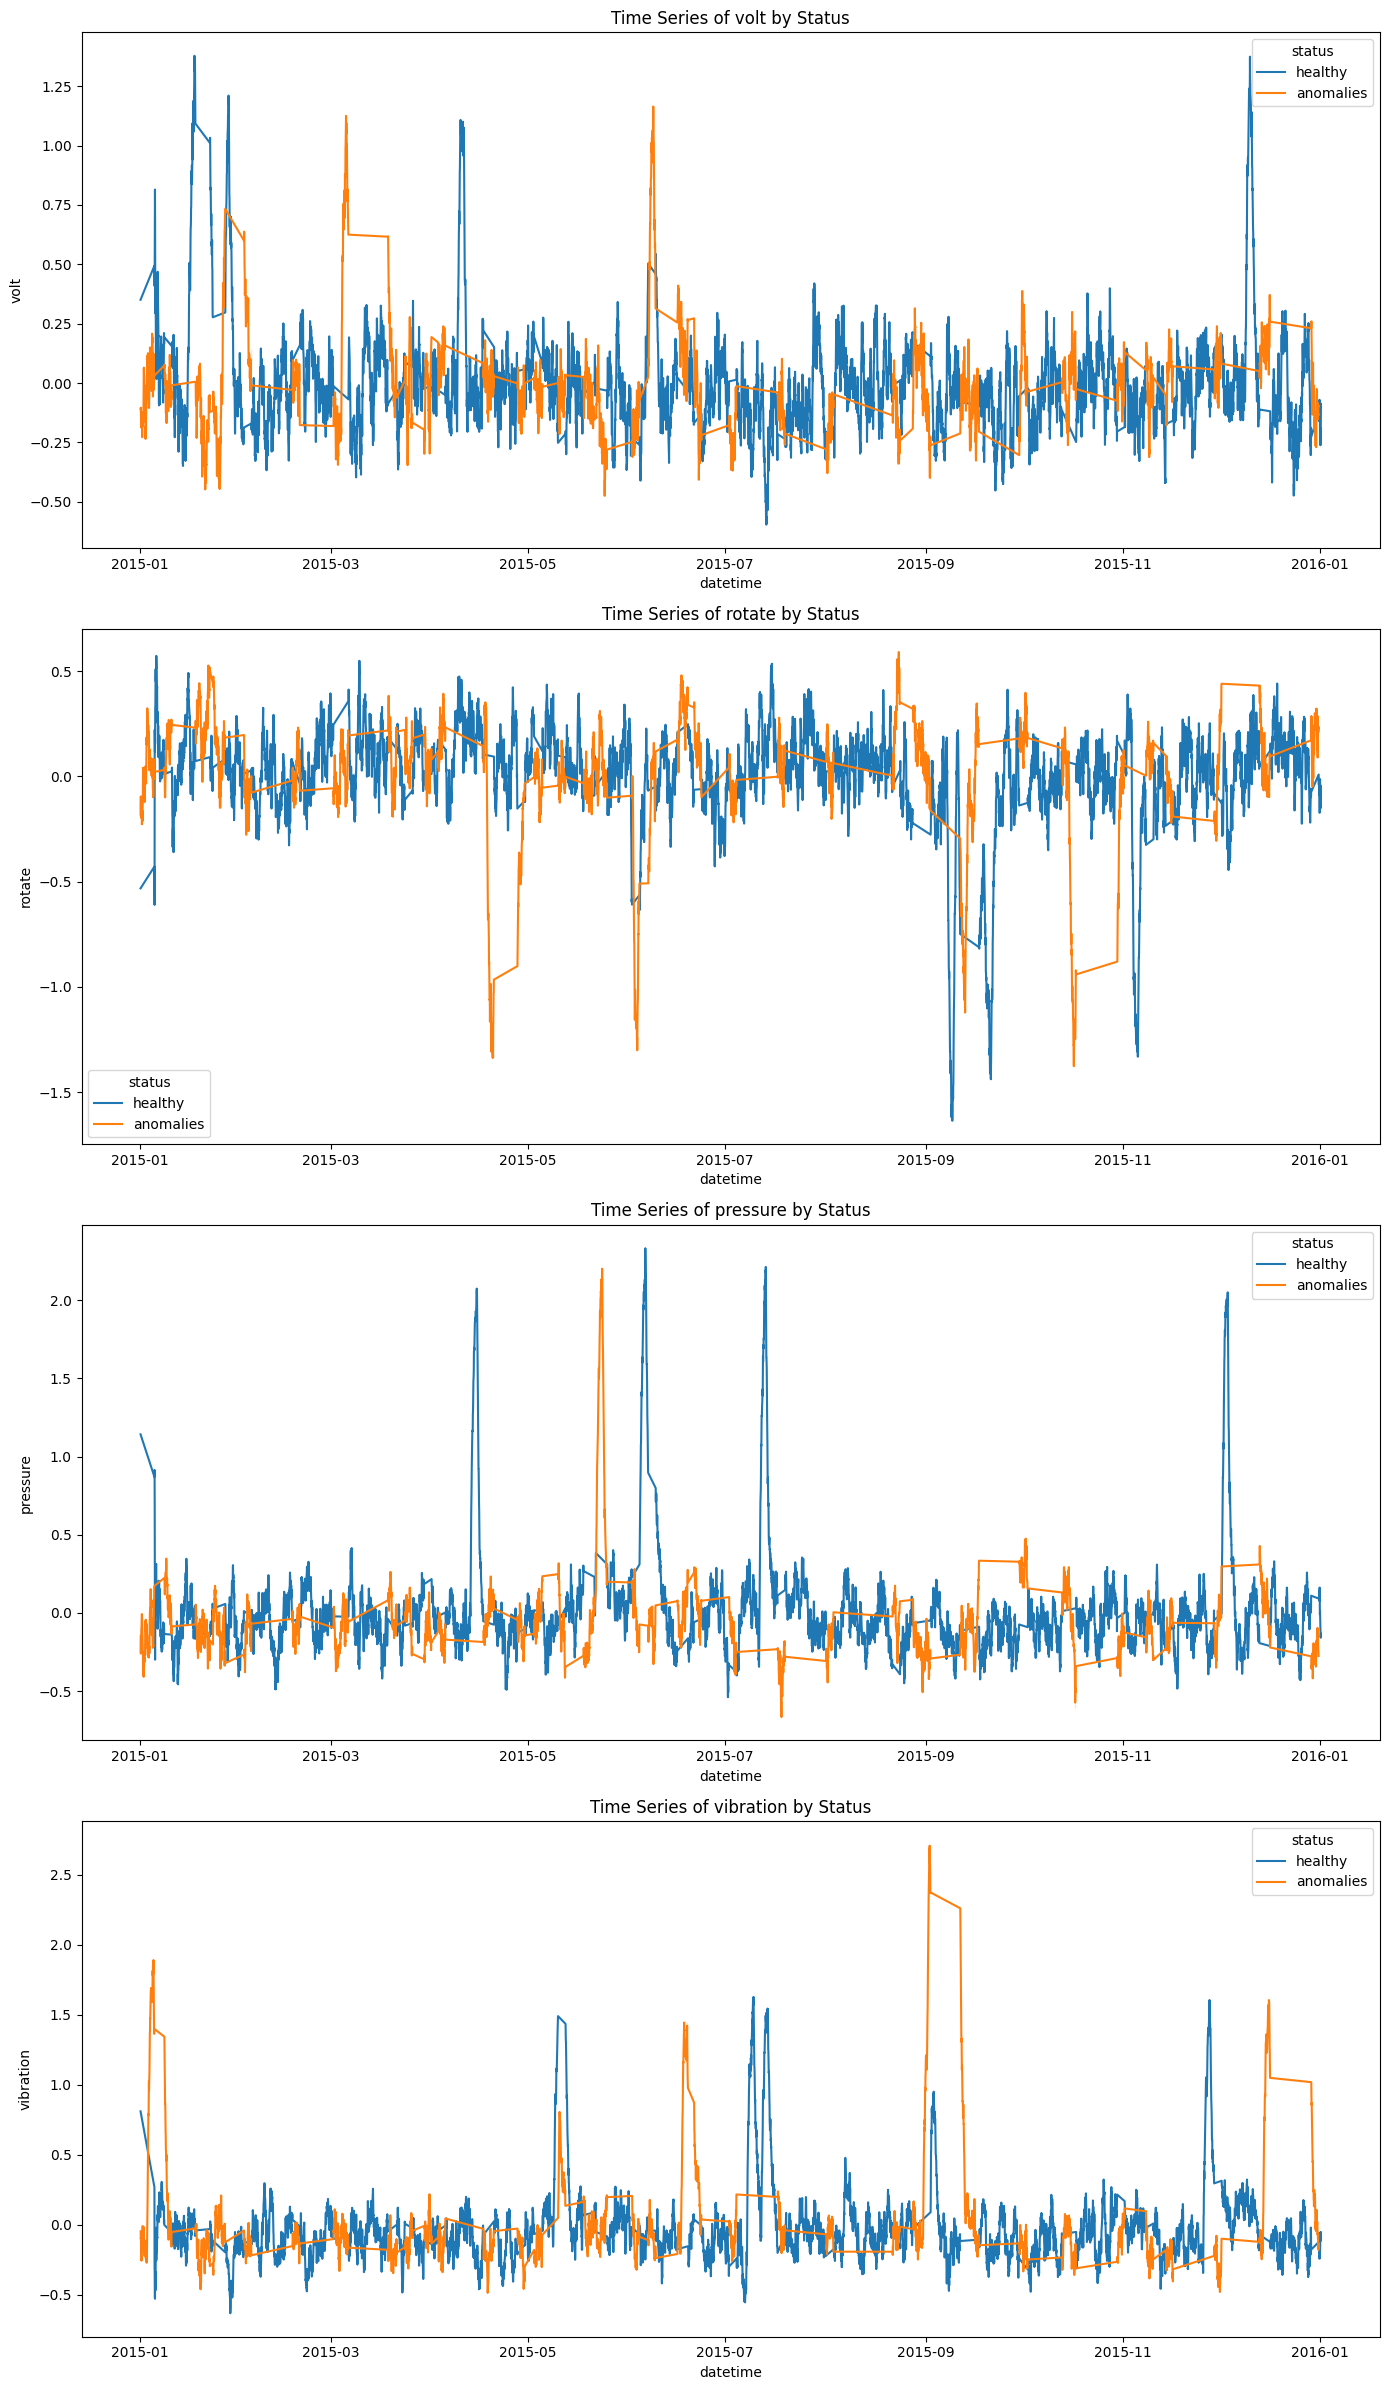

In [73]:
alpha = 0.05
first_machine_data_smooth = first_machine_data.copy()

for variable in variables:
    first_machine_data_smooth[variable] = (
        first_machine_data_smooth[variable].ewm(alpha=alpha).mean()
    )

fig, axes = plt.subplots(len(variables), figsize=(14, 6 * len(variables)))
for ax, variable in zip(axes, variables):
    sns.lineplot(
        x="datetime", y=variable, hue="status", data=first_machine_data_smooth, ax=ax
    )
    ax.set_title(f"Time Series of {variable} by Status")
plt.tight_layout()
plt.show()

#### Distribution of data

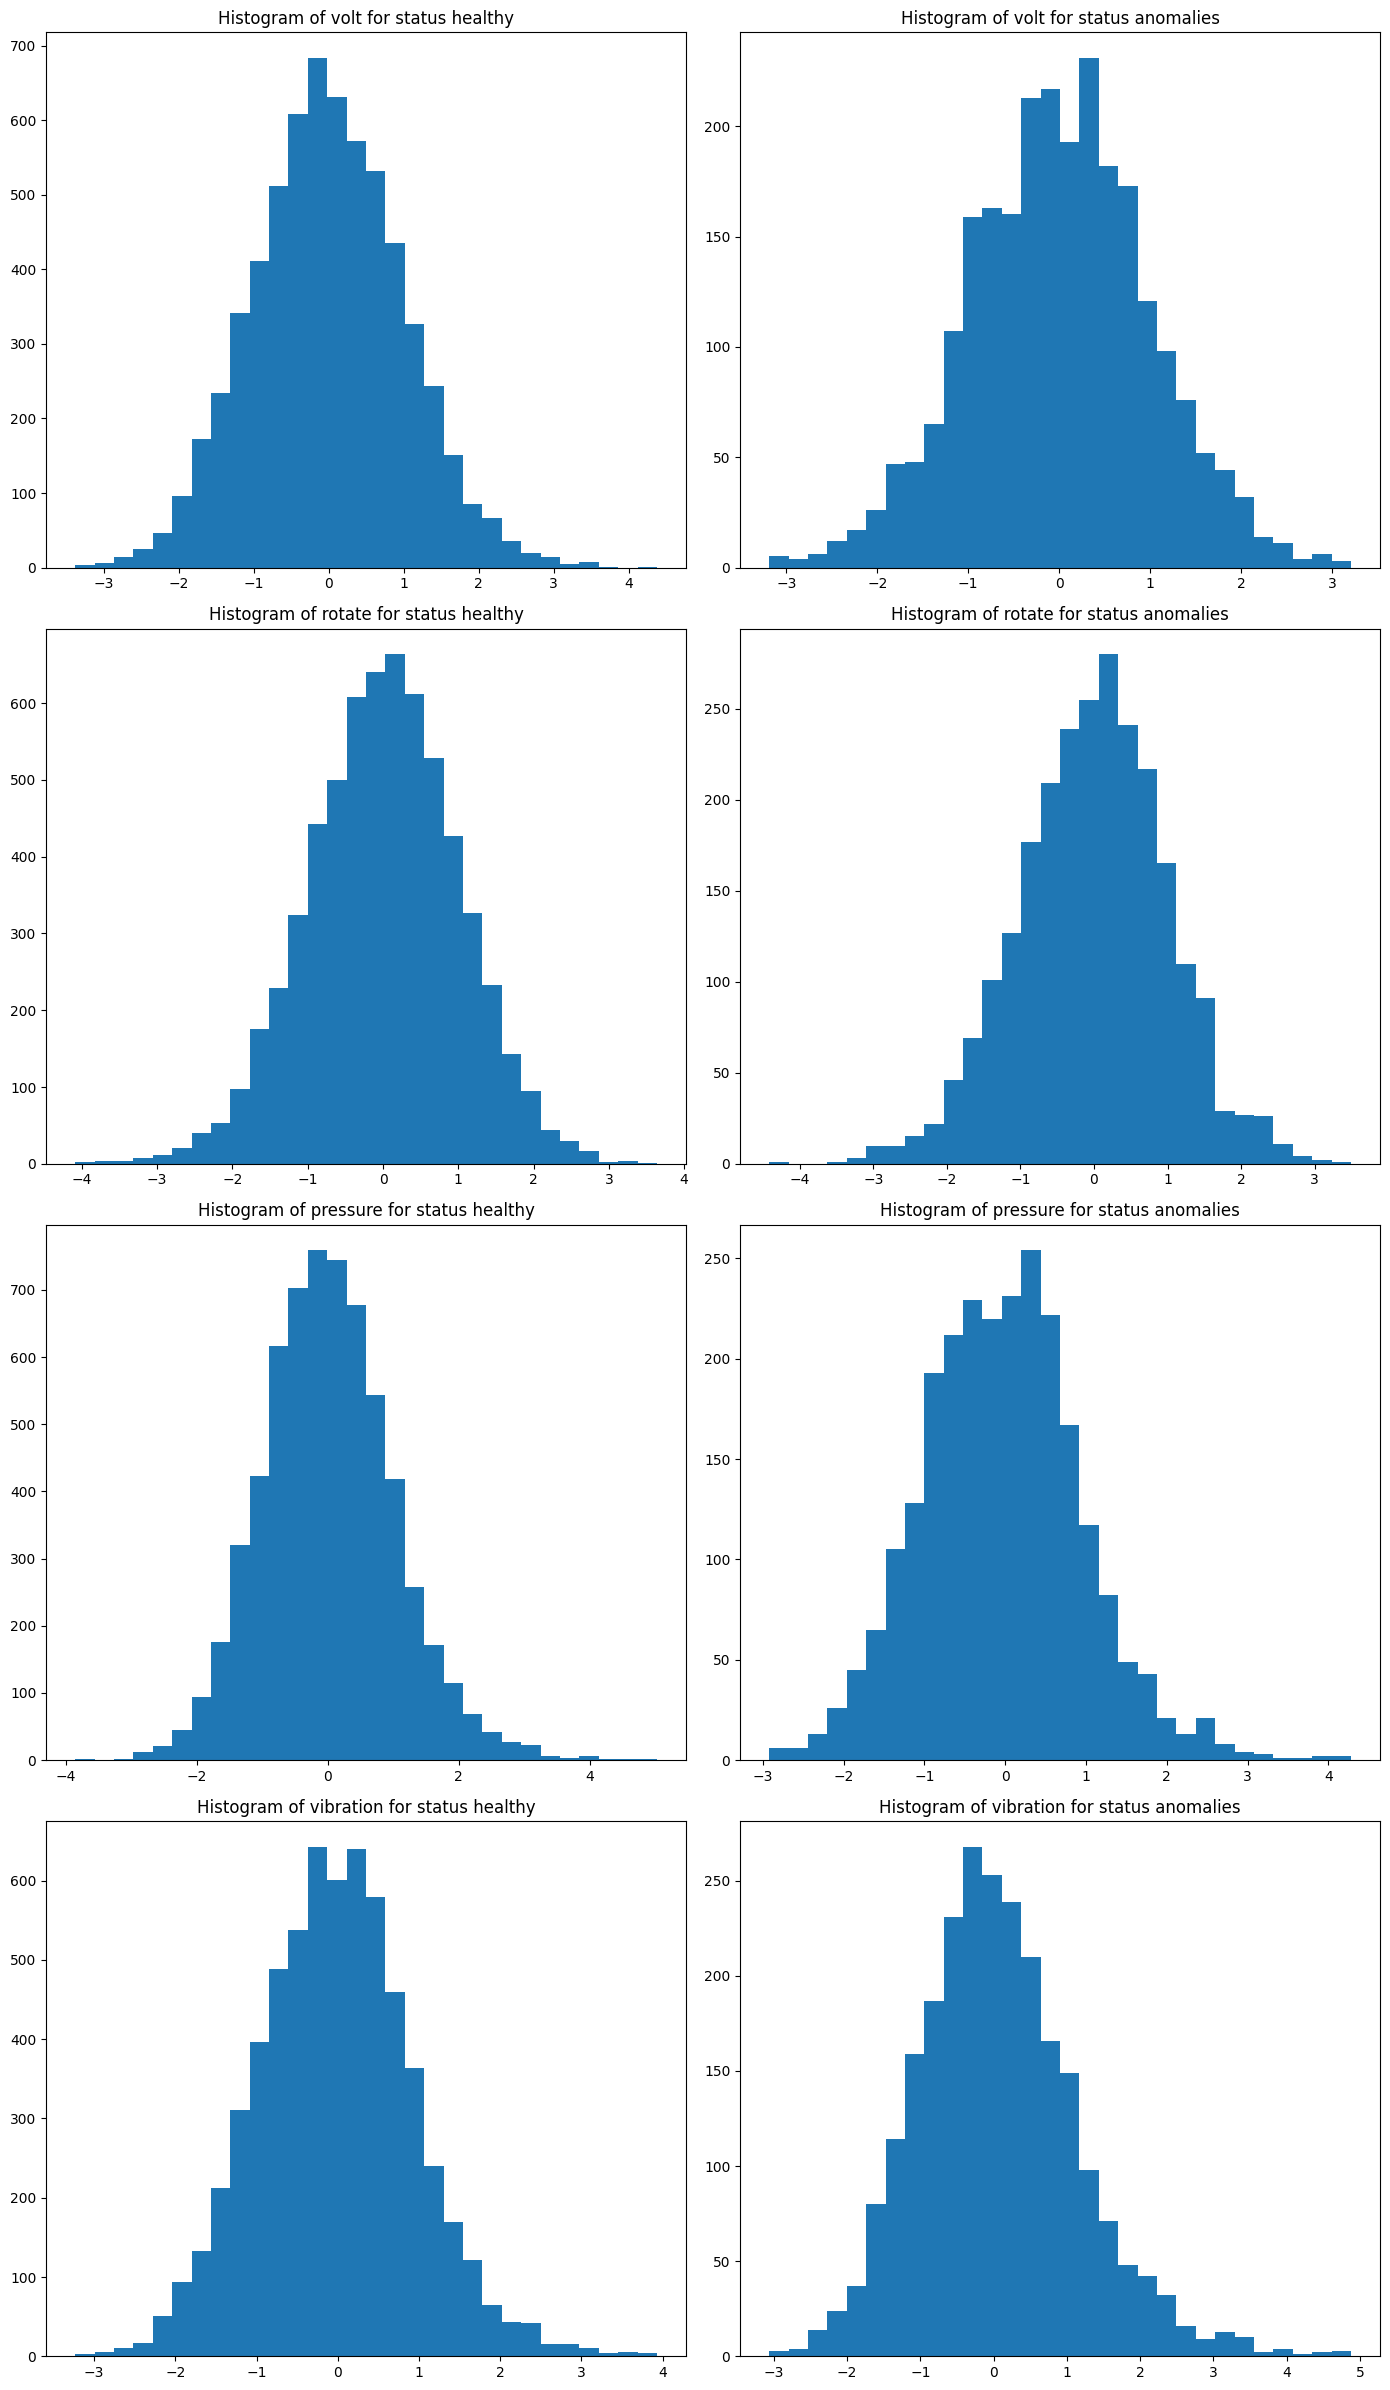

In [74]:
fig, axes = plt.subplots(len(variables), 2, figsize=(14, 6 * len(variables)))

statuses = first_machine_data["status"].unique()

for ax_row, variable in zip(axes, variables):
    for ax, status in zip(ax_row, statuses):
        data = first_machine_data[first_machine_data["status"] == status][variable]
        ax.hist(data.dropna(), bins=30)
        ax.set_title(f"Histogram of {variable} for status {status}")

plt.tight_layout()
plt.show()